# GID-Tomography 

In [1]:
import os, glob, time, sys, tomopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from joblib import Parallel, delayed
from scipy import signal

HOME_PATH = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs/'
GI_TOMO_PATH = HOME_PATH+'GI_tomo/'
GI_TOMO_PATH in sys.path or sys.path.append(GI_TOMO_PATH)

import analysis.peaks as peaks
import analysis.tomo as tomo
import analysis.seg as seg
import analysis.util as util
import analysis.io as io


util.print_time()

%pwd

2023/07/05 11:38:55



'/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs/analysis/GI_tomo'

## (0) Specify param

In [2]:
# =============================================================================
# Specify input
# =============================================================================
os.chdir(HOME_PATH)
#source_dir = './stitched/'
source_dir = './raw/'
out_dir = './analysis/results_tomo/'
infiles = glob.glob(os.path.join(source_dir, '*WAXSpos2*_pos1*.tiff')) #TIFF or NPZ
print(infiles[0])
N_files = len(infiles); print('N_files = {}'.format(N_files))

filename = 'sam3'; print(filename)
if os.path.exists(out_dir) is False: os.mkdir(out_dir)
if 'npz' in infiles[0]:
    infile_type = 'npz'
else:
    infile_type =  'tiff'          

    
#### Steps (**only for the first time)
# 1) **Load some 2D data to see peak locations
# 2) **Select/Load roi for peaks 
# 3) **Get peaks from each 2D data. NOTE: slow due to many files
# 4) Generate sinogram for each domain 
# 5) Label peak positons (in deg) for sinos. Use the largest domain (high-intensity peak) to define the set of angles corresponding to one domain.
# 6) Refer to previous step, select domains
# 7) For each domain, generate sinogram and recon
# 8-10) Post-processing/Visualization

run_steps = [1] 
flag_LinearSubBKG = 0
flag_load_peaks = 1 
flag_save_png = 0
flag_save_npy = 0
extra='_more'
verbose = 0



./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_56_x0.200_th0.120_1.00s_790318_000088_waxs.tiff
N_files = 7560
sam3


In [3]:
7560/360

21.0

## (1) Load input files

In [3]:
# =============================================================================
# Load all/some data and plot sum
# =============================================================================
if 1 in run_steps:
    t0 = time.time()   
    fraction = 1  # Quick checck peak positions
    for ii, infile in enumerate(infiles):
        if ii%1000==0: 
            print("{}/{}, {}".format(ii, N_files, infile))  
        if ii%fraction==0: 
            if infile_type == 'npz':
                temp = np.load(infile)
                data = temp['image']
                x_axis = temp['x_axis']
                y_axis = temp['y_axis']
            else:
                temp = Image.open(infile).convert('I')
                data = np.copy(np.asarray(temp))
            if ii==0:
                data_sum = data
            else:
                data_sum = data_sum+data
    data_avg = data_sum/np.size(infiles)*fraction    
    print("Loading data took {:.0f} s".format(time.time()-t0))
        

0/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_56_x0.200_th0.120_1.00s_790318_000088_waxs.tiff
1000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_49_x-1.200_th0.120_1.00s_790311_000081_waxs.tiff
2000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_58_x0.600_th0.120_1.00s_790320_000257_waxs.tiff
3000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_64_x1.800_th0.120_1.00s_790326_000228_waxs.tiff
4000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_53_x-0.400_th0.120_1.00s_790315_000079_waxs.tiff
5000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_51_x-0.800_th0.120_1.00s_790313_000241_waxs.tiff
6000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_58_x0.600_th0.120_1.00s_790320_000239_waxs.tiff
7000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_56_x0.200_th0.120_1.00s_790318_000355_waxs.tiff
Loading data took 1 s


__Plot 2D__

Text(0.5, 1.0, 'Average over 7560 data (fraction=1/1) \n ./raw/GITOMO_perovskites_s3_WAXSpos2_pos1_56_x0.200_th0.120_1.00s_790318_000088_waxs.tiff')

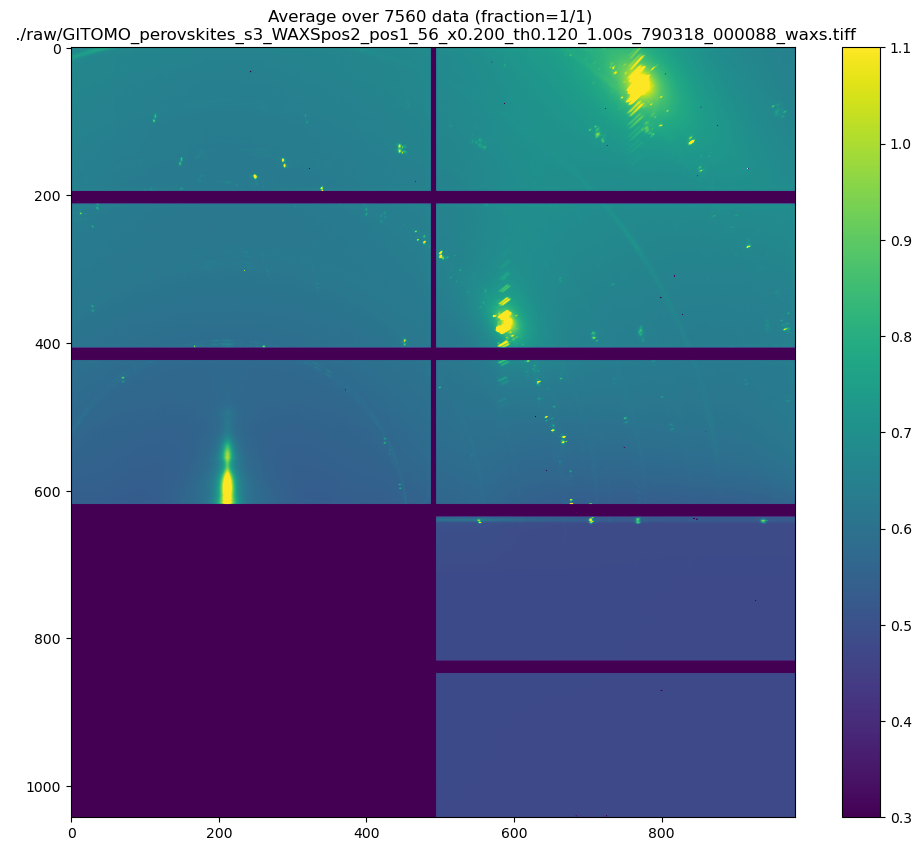

In [5]:
data_avg = np.nan_to_num(data_avg)

# Plot    
plt.figure(1, figsize=(12,10)); plt.clf()
if infile_type == 'npz':
    extent = (np.nanmin(x_axis), np.nanmax(x_axis), np.nanmin(y_axis), np.nanmax(y_axis))
    plt.imshow((data_avg+3), origin='bottom', extent=extent) #, vmin=0.5, vmax=1.8) 
    plt.ylim(0, np.nanmax(y_axis))
    #plt.grid(axis='x'); plt.colorbar()
else:
    plt.imshow(np.log10(data_avg+3), vmin=0.3, vmax=1.1)
plt.colorbar()
plt.title('Average over {} data (fraction=1/{}) \n {}'.format(N_files,fraction,infiles[0]))



__Save summed 2D data__

In [4]:
# Save png
flag_save_png = 1
flag_save_npy = 1

if flag_save_png:
    fn_out = out_dir+'fig1_'+filename+'_data_avg_WAXS2'
    fn_out = util.check_file_exist(fn_out, ext='.png')
    plt.savefig(fn_out, format='png')

# Save as npy
if flag_save_npy:
    fn_out = out_dir+filename+'data_avg_WAXS2'
    fn_out = util.check_file_exist(fn_out, ext='.npy')
    np.save(fn_out, data_avg)
    if False:
        fn_out = out_dir+filename+'data_avg_WAXS2'
        data_avg = np.load(fn_out+'.npy')

# Save as tiff
if True:
    data_avg = np.nan_to_num(data_avg)
    final_img = Image.fromarray(data_avg.astype(np.uint32))
    infile_done = out_dir+filename+'_data_avg_WAXS2'
    infile_done = util.check_file_exist(infile_done, ext='.tiff')
    final_img.save(infile_done)     

    # Plot qr (after use SciAnalysis on the tiff file)
    if 0:
        fn = './waxs/analysis/qr_image/TOMO_T1_real_data_avg.npz'
        qinfo = np.load(fn)
        qr_image = qinfo['image']
        x_axis = qinfo['x_axis']
        y_axis = qinfo['y_axis']
        extent = (np.nanmin(x_axis), np.nanmax(x_axis), np.nanmin(y_axis), np.nanmax(y_axis))
        plt.figure(11, figsize=[12,8]); plt.clf()
        plt.imshow(np.log10(qr_image), origin='bottom', extent=extent, vmin=1.1, vmax=1.8) 
        plt.ylim(0, np.nanmax(y_axis))
        plt.grid(axis='x'); plt.colorbar()
        plt.title(fn)

        fn_out = out_dir+filename+'_qr.png'
        plt.savefig(fn_out, format='png')

    # Load and plot
    if False:
        temp = Image.open(infile_done).convert('I') # 'I' : 32-bit integer pixels
        data_avg_infile = np.copy( np.asarray(temp) )
        plt.figure(2); plt.clf()
        plt.imshow(data_avg_infile)
        plt.clim(0, 20)
        plt.colorbar()
        plt.show()


Saving to ./analysis/results_tomo/fig1_sam3_data_avg_WAXS2_1.png
Saving to ./analysis/results_tomo/sam3data_avg_WAXS2_1.npy
Saving to ./analysis/results_tomo/sam3_data_avg_WAXS2_1.tiff


<Figure size 640x480 with 0 Axes>

In [37]:
fn = 'data_avg_WAXS2.png'
ext = fn.split(".")[-1]
print(ext)

png


## (2) Get peak ROI

Specify in TXT the center, size, peak:

[[575, 252], [60, 10], 'sum002'],


In [ ]:
## Get ROI for each peak from 2D data (step 2)
filename_peak = './GI_tomo/param/C8BTBT_peaks.txt'
filename_df_peaks = 'df_peaks_all_subbg{}{}'.format(flag_LinearSubBKG, extra)


####### Get peak roi from scattering pattern
peak_list = io.read_peak_list(filename_peak)

if 0:
    q_file = HOME_PATH+'analysis/q_image/TOMO_S4_sam3_R_10_x-3.400_th0.110_1.00s_42366_000000_waxs.npz'
    temp = np.load(q_file)
    q_image = temp['image']
    x_axis = temp['x_axis'] 
    y_axis = temp['y_axis'] 
    x_scale = temp['x_scale'] 
    y_scale = temp['y_scale'] 
    #fig = plt.figure(4, figsize=[8,8]); plt.clf(); 
    #X, Y = np.meshgrid(x_axis, y_axis)
    #plt.pcolormesh(X, Y, np.log10(q_image))
#    calibration.set_beam_position(462, 1043-398)

if 2 in run_steps:     
    #### Plot to define roi
    fig = plt.figure(5, figsize=[12,12]); plt.clf(); 
    plt.title(filename)
    ax = fig.add_subplot(111)
    ax.imshow(np.log10(data_avg), vmin=0.5, vmax=1.25)
    peaks.get_peaks(infiles[0], peak_list, phi_max=360, verbose=2)
    #ax.set_xlim(145,981)
    #ax.set_ylim(670,0)

    if 0:
        xticks = np.asarray([471+ii*109.6 for ii in np.arange(-3, 4.1, 1)])
        xticklabels = ["{:5.1f}".format(i) for i in ((xticks-471)*x_scale)];
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        yticks = xticks = np.asarray([651+ii*109.6 for ii in np.arange(0, -6, -1)])
        yticklabels = ["{:5.1f}".format(i) for i in ((651-yticks)*y_scale)];
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
    
    ## Save png
    if flag_save_png:
        fn_out = out_dir+'fig5_'+filename+'_peak_roi.png'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')
    
    ## Save peak_list in npy
    if flag_save_npy:
        fn_out = out_dir+'peak_list'
        fn_out = util.check_file_exist(fn_out)
        np.save(fn_out, peak_list)
